In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost
import sys
sys.path.append("./skynet/bf/src/scripts/")
import xgboost_ohlc
import utils
import numpy as np
import seaborn as sns
import talib
import datetime
import dateutil
import requests
import time
%matplotlib inline

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
pd.options.display.precision = 10

In [2]:
version = '3000'
rate = 0.00025
data_size=200000
data_columns = ['MACDS/O','RSI','ATR/O','C/O','O-1/C','H/O','L/O','SignLine','3SignLine']
target_column = 'Target_Pure_Convergence'
backtest_columns = ['Open','High','Low','Close']

In [3]:
seconds = pd.read_csv('skynet/bf/data/processed/seconds.csv')

In [4]:
seconds['Target_Pure_Convergence'] = seconds['Pure_Convergence']

In [5]:
seconds = utils.shaping_ohlc(seconds,['Open','Close']+data_columns+[target_column])

In [6]:
xgbc,predict,test,all_data = xgboost_ohlc.c_model_generate(version=version,ohlc=seconds,data_columns=data_columns,target_column=target_column,data_size=data_size,over_fit=True)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.7s finished


0.67
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.6s finished


In [60]:
threshold = 0.3117
income = [0]
cnt1 = 0
cnt2 = 0
for i,p in enumerate(predict):
    if p > threshold:
        income.append(income[-1]+0.01*(1 if test.values[i] else -1)*(2*rate)*all_data[-1000:]['Close'].values[i])
        if test.values[i]:
            cnt1+= 1
        else:
            cnt2 +=1
    else:
        income.append(income[-1])

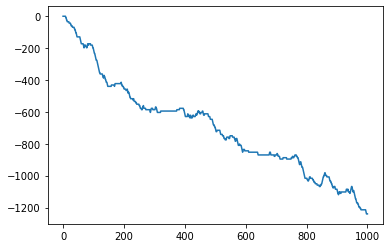

In [52]:
plt.plot(income)

In [15]:
np.ceil(1.9)

2.0

In [70]:
executions = pd.read_csv('skynet/bf/data/raw/executions.csv')
executions['exec_date'] = executions['exec_date'].apply(lambda x: dateutil.parser.parse(x).timestamp())
executions['exec_date_ceil'] = executions['exec_date'].apply(np.ceil).astype(int)
grouped = executions.groupby('exec_date_ceil')
seconds = pd.DataFrame()
seconds['timestamp'] = grouped['exec_date_ceil'].first()
seconds['Open'] = grouped['price'].first()
seconds['High'] = grouped['price'].max()
seconds['Low'] = grouped['price'].min()
seconds['Close'] = grouped['price'].last()
seconds = seconds.reset_index(drop=True)

seconds['Pure_Convergence'] = False
#どっちに先に到達しているかを確認するためのcode
rate = 0.00025
for i in range(seconds.shape[0]-1):
    base = seconds['Close'].values[i]
    upper = False
    lower = False
    flag = False
    cnt = 1
    while i+cnt <= seconds.shape[0]-1:
        if base*(1+rate) <= seconds['High'].values[i+cnt]:
            upper = True
            if base*(1+2*rate) <= seconds['High'].values[i+cnt]:
                break
                
        if seconds['Low'].values[i+cnt] <= base*(1-rate):
            lower = True
            if seconds['Low'].values[i+cnt] <= base*(1-2*rate):
                break
                
        if upper and lower:
            flag = True
            break
            
        cnt += 1
        
    seconds['Pure_Convergence'].values[i] = flag
    
seconds.to_csv('skynet/bf/data/processed/seconds.csv',index=False)

In [17]:
seconds.copy()

,Open,Close,MACDS/O,RSI,ATR/O,C/O,O-1/C,H/O,L/O,SignLine,3SignLine,Target_Pure_Convergence
0,1701000.0,1701422.0,NaN,NaN,NaN,1.0002480894,NaN,1.0002480894,0.9999900059,1,NaN,False
1,1701422.0,1701173.0,NaN,NaN,NaN,0.9998536518,0.9998983055,1.0000858106,0.9996279583,-1,NaN,False
2,1701173.0,1701116.0,NaN,NaN,NaN,0.9999664937,1.0001798819,1.0000000000,0.9997648681,-1,-1.0,False
3,1700943.0,1700898.0,NaN,NaN,NaN,0.9999735441,1.0001616793,1.0000423295,0.9998636051,-1,-3.0,False
4,1700889.0,1700763.0,NaN,NaN,NaN,0.9999259211,1.0001058349,1.0000064672,0.9998065717,-1,-3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60524,1721171.0,1721240.0,0.0000417317,64.2243587842,0.0000879340,1.0000400890,0.9998820618,1.0000400890,1.0000000000,1,3.0,False
60525,1721337.0,1721468.0,0.0000378211,68.5899418906,0.0000884168,1.0000761036,0.9998274728,1.0000946938,1.0000000000,1,3.0,False
60526,1721260.0,1721260.0,0.0000200930,61.2472606631,0.0000821014,1.0000000000,1.0000447347,1.0000000000,1.0000000000,1,3.0,False
60527,1721468.0,1721245.0,-0.0000159353,60.7422532595,0.0000868176,0.9998704594,1.0000087146,1.0000185888,0.9998704594,-1,1.0,False
